In [2]:
import pandas as pd
from binance.client import Client
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')
from scipy.signal import argrelextrema

In [3]:
api_secret = ''
api_key = ''
client = Client(api_key, api_secret)

In [4]:
symbol = 'BTCUSDT'
time = '50 day ago utc'
klines = client.get_historical_klines(symbol, Client.KLINE_INTERVAL_12HOUR,time)
df = pd.DataFrame(klines, columns=['time', 'open', 'high','low','close','None', 'None', 'None','None','None','None','None'])
df.index = [x for x in range(1, len(df.values)+1)]
df = df.drop('None', axis=1)
df['open'], df['high'] = pd.to_numeric(df['open'], errors ='coerce'), pd.to_numeric(df['high'], errors ='coerce')
df['low'], df['close'] = pd.to_numeric(df['low'], errors ='coerce'), pd.to_numeric(df['close'], errors ='coerce')
df['ind'] = df.index

In [5]:
n = 5

df['max_'] = df.iloc[argrelextrema(df.close.values, np.greater_equal, order=n)[0]]['close']
df['max_h'] = df.iloc[argrelextrema(df.high.values, np.greater_equal, order=n)[0]]['high']

df['min_'] = df.iloc[argrelextrema(df.close.values, np.less_equal, order=n)[0]]['close']
df['min_l'] = df.iloc[argrelextrema(df.low.values, np.less_equal, order=n)[0]]['low']

dfMax_, dfMin_ = df[df['max_'].notnull()], df[df['min_'].notnull()]
dfMax_h, dfMin_l = df[df['max_h'].notnull()], df[df['min_l'].notnull()]

dfMax_h = dfMax_h[['high','ind']]
dfMax_h = dfMax_h.rename(columns={'high':'close'})
dfMax_ = dfMax_.append(dfMax_h)

dfMin_l = dfMin_l[['low','ind']]
dfMin_l = dfMin_l.rename(columns={'low':'close'})
dfMin_ = dfMin_.append(dfMin_l)

dfMax_.index, dfMin_.index = [x for x in range(1, len(dfMax_.values)+1)], [x for x in range(1, len(dfMin_.values)+1)]

dfMax_, dfMin_ = dfMax_[['close','ind']], dfMin_[['close','ind']]

In [6]:
nb=0
liste_plot_r = []
liste_plot_r_start = []
combinaison = list(combinations(dfMax_.index,3))

for element in combinaison:
    lst1 = dfMax_['close'][element[0]], dfMax_['close'][element[1]], dfMax_['close'][element[2]]
    lst2 = dfMax_['ind'][element[0]], dfMax_['ind'][element[1]], dfMax_['ind'][element[2]]
    
    if len(set(lst2)) == 3:
        if np.corrcoef(lst1,lst2)[0][1] >= 0.999 or np.corrcoef(lst1,lst2)[0][1] <= -0.999:
            variancex = pd.DataFrame(lst2).var()[0]
            variancey = pd.DataFrame(lst1).var()[0]
            cov = np.cov(lst1,lst2)[0][1]

            a=(cov)/variancex
            b = np.mean(lst1) - (a*(np.mean(lst2)))
            
            témoin = a * df['ind'][np.min(lst2)-1:np.max(lst2)] + b
            
            if all(df['close'][np.min(lst2)-1:np.max(lst2)] < (témoin*1.001)):
                bet = df.loc[df.index[int(np.max(lst2)-1)+n:],['close','ind']]
                bet = bet[['close','ind']].append(df.loc[df.index[int(np.max(lst2)-1)+n:],['high','ind']])
                bet['new'] = bet['close'].fillna(bet['high'])
                bet = bet[['ind','new']]
                bet = bet.sort_values('ind')
                
                for i1 in bet.iterrows():
                    
                    lst_t = list(lst1)
                    lst_t.append(i1[1][1])
                    lst_t = tuple(lst_t)
                    lst_k = list(lst2)
                    lst_k.append(i1[1][0])
                    lst_k = tuple(lst_k)
                    if (np.corrcoef(lst_t,lst_k)[0][1]) > 0.999 or (np.corrcoef(lst_t,lst_k)[0][1]) < -0.999:
                        df.loc[df.index[int(np.max(lst_k)-1):],'r'+str(nb)] = a*df['ind']+b
                        df.loc[df.index[int(np.min(lst_k)-1):int(np.max(lst_k))],'r_start'+str(nb)] = a*df['ind']+b
                        
                        df.loc[df.index[int(np.max(lst_k)-1)],'point_r'] = lst_t[-1]

                        liste_plot_r.append('r'+str(nb))
                        liste_plot_r_start.append('r_start'+str(nb))
                        nb+=1
                        break

In [7]:
liste_plot_s = []
liste_plot_s_start = []
combinaison = list(combinations(dfMin_.index,3))

for element in combinaison:
    lst1 = dfMin_['close'][element[0]], dfMin_['close'][element[1]], dfMin_['close'][element[2]]
    lst2 = dfMin_['ind'][element[0]], dfMin_['ind'][element[1]], dfMin_['ind'][element[2]]
    
    if len(set(lst2)) == 3:   
        if np.corrcoef(lst1,lst2)[0][1] >= 0.999 or np.corrcoef(lst1,lst2)[0][1] <= -0.999:
            variancex = pd.DataFrame(lst2).var()[0]
            variancey = pd.DataFrame(lst1).var()[0]
            cov = np.cov(lst1,lst2)[0][1]

            a=(cov)/variancex
            b = np.mean(lst1) - (a*(np.mean(lst2)))

            témoin = a * df['ind'][np.min(lst2)-1:np.max(lst2)] + b
            
            if all(df['close'][np.min(lst2)-1:np.max(lst2)] > (témoin*0.999)):            
                bet = df.loc[df.index[int(np.max(lst2)-1)+n:],['close','ind']]
                bet = bet[['close','ind']].append(df.loc[df.index[int(np.max(lst2)-1)+n:],['low','ind']])
                bet['new'] = bet['close'].fillna(bet['low'])
                bet = bet[['ind','new']]
                bet = bet.sort_values('ind')
               
                for i1 in bet.iterrows():
                    
                    lst_t = list(lst1)
                    lst_t.append(i1[1][1])
                    lst_t = tuple(lst_t)
                    
                    lst_k = list(lst2)
                    lst_k.append(i1[1][0])                        
                    lst_k = tuple(lst_k)                
                    if (np.corrcoef(lst_t,lst_k)[0][1]) > 0.999 or (np.corrcoef(lst_t,lst_k)[0][1]) < -0.999:  
                        df.loc[df.index[int(np.max(lst_k)-1):],'s'+str(nb)] = a*df['ind']+b
                        df.loc[df.index[int(np.min(lst_k)-1):int(np.max(lst_k))],'s_start'+str(nb)] = a*df['ind']+b
                            
                        df.loc[df.index[int(np.max(lst_k)-1)],'point_s'] = lst_t[-1]

                        liste_plot_s.append('s'+str(nb))
                        liste_plot_s_start.append('s_start'+str(nb))
                        nb+=1
                        break

In [8]:
df = df[df > (df['low'].min()*0.999)]
df = df[df < (df['high'].max()*1.001)]

ressistance_plot = df[liste_plot_r]
support_plot = df[liste_plot_s]

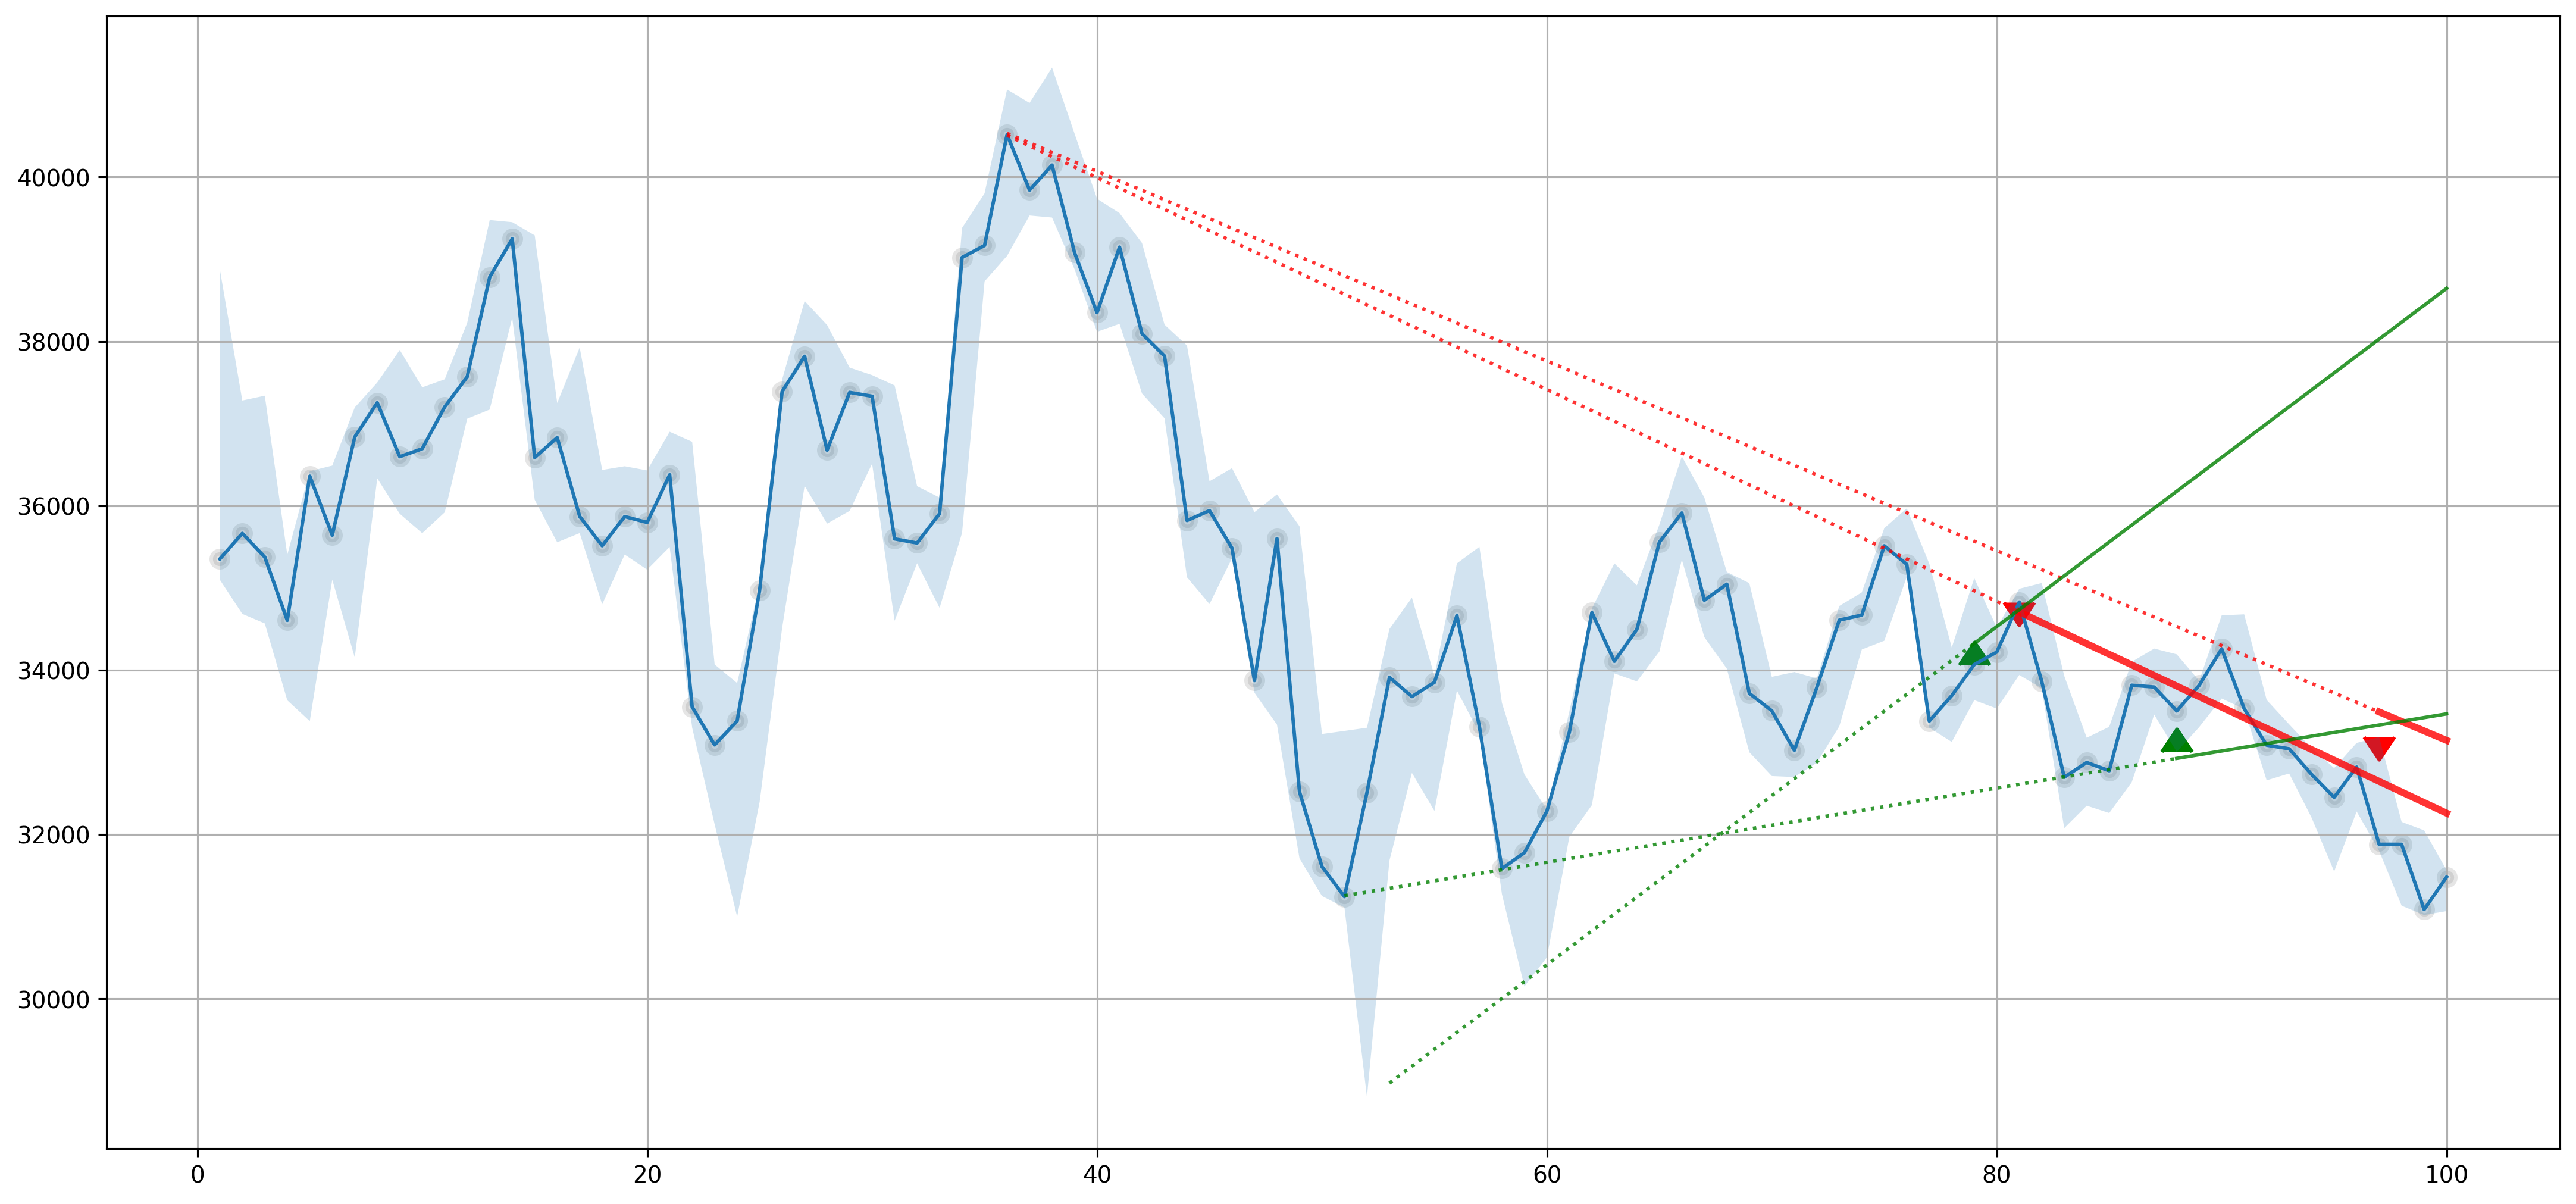

In [9]:
plt.figure(figsize=(19,9),dpi=280)
plt.plot(df.index,df.close)
plt.scatter(df.index,df.close,alpha=0.2,lw=3,c='gray')
try:
    plt.plot(df.index,ressistance_plot,c='red',alpha=0.8,lw=3)
    plt.plot(df.index,df[liste_plot_r_start],c='red',alpha=0.8,ls=':')
    plt.scatter(df.index,df.point_r,c='red',marker=11,s=172)
except:
    pass
try:
    plt.plot(df.index,support_plot,c='green',alpha=0.8)
    plt.plot(df.index,df[liste_plot_s_start],c='green',alpha=0.8,ls=':')
    plt.scatter(df.index,df.point_s,c='green',marker=10,s=172)
except:
    pass
plt.fill_between(df.index, df['high'], df['low'], alpha=0.2)
plt.grid()
plt.show()